In [1]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.57.3
!pip install --no-deps trl==0.22.2
!pip install torchcodec

In [2]:
%%capture
!pip install --no-deps --upgrade timm # Only for Gemma 3N

In [3]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

model, processor = FastVisionModel.from_pretrained(
    "unsloth/medgemma-1.5-4b-it",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2026-02-21 17:49:08.026232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771696148.158254     106 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771696148.194924     106 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771696148.525434     106 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771696148.525465     106 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771696148.525467     106 computation_placer.cc:177] computation placer alr

🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2026.2.1: Fast Gemma3 patching. Transformers: 4.57.3.
   \\   /|    NVIDIA H100 80GB HBM3. Num GPUs = 1. Max memory: 79.179 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 9.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

In [4]:
train_path = "/kaggle/input/datasets/wlsgusjin/ntds-dataset-final/dataset/train.json"
valid_path = "/kaggle/input/datasets/wlsgusjin/ntds-dataset-final/dataset/valid.json"
test_path  = "/kaggle/input/datasets/wlsgusjin/ntds-dataset-final/dataset/test.json"

In [5]:
from datasets import load_dataset, Image
dataset = load_dataset(
    'json',
    data_files={
        'train': f"{train_path}",
        'valid': f"{valid_path}",
    }
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating valid split: 0 examples [00:00, ? examples/s]

In [6]:
def convert_to_conversation(sample):
    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "What skin features are visible in this image?"},
                {"type": "image", "image": sample["image"]},
            ],
        },
        {"role": "assistant", "content": [{"type": "text", "text": sample["prompt"]}]},
    ]
    return {"messages": conversation}
pass

In [7]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset["train"]]
converted_dataset_val = [convert_to_conversation(sample) for sample in dataset["valid"]]

In [8]:
import random
test_idx = random.randint(0,len(dataset["valid"])-1)
test_img = dataset["valid"][test_idx]["image"]

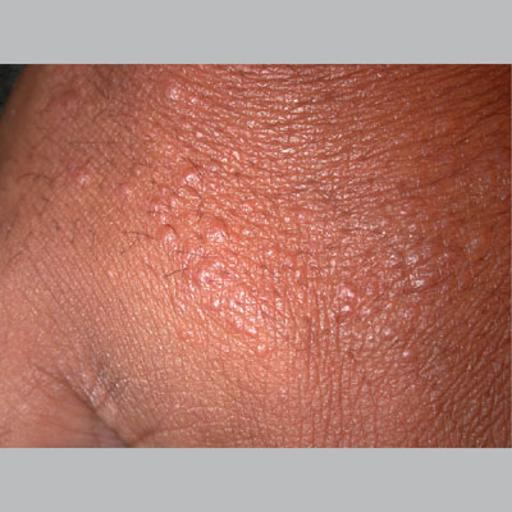

In [9]:
from PIL import Image

Image.open(test_img).convert('RGB')

In [10]:
dataset["valid"][test_idx]["prompt"]

'allergic contact dermatitis'

In [11]:
%%time
FastVisionModel.for_inference(model)  # Enable for inference!

image = Image.open(test_img).convert('RGB')
instruction = "What skin features are visible in this image?"

messages = [
    {
        "role": "user",
        "content": [{"type": "image"}, {"type": "text", "text": instruction}],
    }
]

input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    image,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda:0")

from transformers import TextStreamer

text_streamer = TextStreamer(processor, skip_prompt=True)
result = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 512,
                        use_cache=True, temperature = 1.0, top_p = 0.95, top_k = 64)

Based on the image, the following skin features are visible:

*   **Small, raised bumps:** These appear to be the most prominent feature, scattered across the skin.
*   **Redness:** The skin appears slightly red or inflamed in some areas.
*   **Possible inflammation:** The overall appearance suggests some level of inflammation.
*   **Skin texture:** The skin texture looks somewhat uneven due to the bumps.

It's important to note that this is just a visual interpretation, and a definitive diagnosis would require a clinical examination and possibly further testing by a healthcare professional.<end_of_turn>
CPU times: user 39.2 s, sys: 2.93 s, total: 42.2 s
Wall time: 1min 41s


In [12]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,                           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,                  # Recommended alpha == r at least
    lora_dropout = 0.05,
    bias = "none",
    random_state = 3407,
    use_rslora = False,               # We support rank stabilized LoRA
    loftq_config = None,               # And LoftQ
    target_modules = "all-linear",    # Optional now! Can specify a list if needed
)

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.


Unsloth: Making `base_model.model.model.vision_tower.vision_model` require gradients


In [14]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

num_train_epochs = 1  # @param {type: "number"}
num_train_steps = 50  # @param {type: "number"}
learning_rate = 2e-4  # @param {type: "number"}

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model=model,
    train_dataset=converted_dataset,
    eval_dataset=converted_dataset_val,
    processing_class=processor.tokenizer,
    data_collator=UnslothVisionDataCollator(
        model, processor,
        train_on_responses_only = True,
        instruction_part = "<start_of_turn>user\n",
        response_part = "<start_of_turn>model\n",
    ),
    args = SFTConfig(
        load_best_model_at_end=True,                             # 2. 가장 좋은 모델을 끝낼 때 불러오는 옵션
        
        metric_for_best_model="eval_loss", 
        greater_is_better=False,                                 # 로스는 낮을수록 좋으니까 False
        
        save_total_limit=2,                                      # 베스트 1개 + 최신 1개 정도만 남기고 삭제
        
        output_dir="medgemma-4b-it-sft-lora",                    # Directory and Hub repository id to save the model to
        #num_train_epochs=num_train_epochs,                       # Number of training epochs
        max_steps=num_train_steps,                               # Number of training steps
        per_device_train_batch_size=1,                           # Batch size per device during training
        per_device_eval_batch_size=1,                            # Batch size per device during evaluation
        gradient_accumulation_steps=4,                           # Number of steps before performing a backward/update pass
        gradient_checkpointing=True,                             # Enable gradient checkpointing to reduce memory usage
        optim="adamw_torch_fused",                               # Use fused AdamW optimizer for better performance
        logging_steps=10,                                        # Number of steps between logs
        save_strategy="steps",                                   # Save checkpoint every epoch
        eval_strategy="steps",                                   # Evaluate every `eval_steps`
        eval_steps=10,                                           # Number of steps between evaluations
        learning_rate=learning_rate,                             # Learning rate based on QLoRA paper
        bf16=True,                                               # Use bfloat16 precision
        max_grad_norm=0.3,                                       # Max gradient norm based on QLoRA paper
        warmup_ratio=0.03,                                       # Warmup ratio based on QLoRA paper
        weight_decay = 0.01,
        seed = 3407,
        lr_scheduler_type="linear",                              # Use linear learning rate scheduler
        report_to="tensorboard",                                 # Report metrics to tensorboard
        gradient_checkpointing_kwargs={"use_reentrant": False},  # Set gradient checkpointing to non-reentrant to avoid issues
        dataset_kwargs={"skip_prepare_dataset": True},           # Skip default dataset preparation to preprocess manually
        remove_unused_columns = False,                           # Columns are unused for training but needed for data collator
        label_names=["labels"],                                  # Input keys that correspond to the labels
    )
)

In [15]:
trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 31,486 | Num Epochs = 1 | Total steps = 50
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 38,497,792 of 4,338,577,264 (0.89% trained)


Step,Training Loss,Validation Loss
10,3.582400,1.024743
20,0.709700,0.588691
30,0.507900,0.461794
40,0.416800,0.425008
50,0.379300,0.399737


Unsloth: Not an error, but Gemma3ForConditionalGeneration does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


TrainOutput(global_step=50, training_loss=1.1192052364349365, metrics={'train_runtime': 576.7722, 'train_samples_per_second': 1.387, 'train_steps_per_second': 0.087, 'total_flos': 5004995312642304.0, 'train_loss': 1.1192052364349365, 'epoch': 0.02540650406504065})

In [16]:
model.save_pretrained_merged("unsloth_finetune", processor,)

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...


Unsloth: Copying 2 files from cache to `unsloth_finetune`: 100%|██████████| 2/2 [00:03<00:00,  1.78s/it]


Successfully copied all 2 files from cache to `unsloth_finetune`
Checking cache directory for required files...


Unsloth: Copying 1 files from cache to `unsloth_finetune`: 100%|██████████| 1/1 [00:00<00:00, 328.81it/s]


Successfully copied all 1 files from cache to `unsloth_finetune`


Unsloth: Merging weights into 16bit: 100%|██████████| 2/2 [00:50<00:00, 25.45s/it]


Unsloth: Merge process complete. Saved to `/kaggle/working/unsloth_finetune`


In [17]:
del model
del trainer
torch.cuda.empty_cache()

In [18]:
from datasets import load_dataset, Image
dataset = load_dataset(
    'json',
    data_files={
        'test': f"{test_path}",
    }
)

Generating test split: 0 examples [00:00, ? examples/s]

In [20]:
from typing import Any

from datasets import load_dataset

PROMPT = f"What skin features are visible in this image?\n"

def format_test_data(example: dict[str, Any]) -> dict[str, Any]:
    example["messages"] = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                },
                {
                    "type": "text",
                    "text": PROMPT,
                },
            ],
        },
    ]
    return example


test_data = dataset['test'].shuffle(seed=42).select(range(len(dataset['test'])))
test_data = test_data.map(format_test_data)

Map:   0%|          | 0/497 [00:00<?, ? examples/s]

In [21]:
test_data

Dataset({
    features: ['image', 'class', 'prompt', 'messages'],
    num_rows: 497
})

In [23]:
!pip install --quiet -U evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.0 MB/s eta 0:00:00


In [24]:
import evaluate

accuracy_metric  = evaluate.load("accuracy")
f1_metric        = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric    = evaluate.load("recall")


# Ground-truth labels
NTDS_CLASSES = list(set(test_data["prompt"]))
label2id = {label: i for i, label in enumerate(NTDS_CLASSES)}

REFERENCES = test_data["prompt"]
REF_IDS = [label2id[label] for label in list(REFERENCES)]
class_type = 0

def compute_metrics(predictions: list[int]) -> dict[str, float]:
    metrics = {}
    metrics.update(accuracy_metric.compute(
        predictions=predictions,
        references=REF_IDS,
    ))
    metrics.update(precision_metric.compute(
        predictions=predictions,
        references=REF_IDS,
        average="weighted",
    ))
    metrics.update(recall_metric.compute(
        predictions=predictions,
        references=REF_IDS,
        average="weighted",
    ))
    metrics.update(f1_metric.compute(
        predictions=predictions,
        references=REF_IDS,
        average="weighted",
    ))
    return metrics

In [25]:
from datasets import ClassLabel

# Rename the class names to the tissue classes, `X: tissue type`
test_data = test_data.cast_column(
    "prompt",
    ClassLabel(names=NTDS_CLASSES)
)

LABEL_FEATURE = test_data.features["prompt"]

Casting the dataset:   0%|          | 0/497 [00:00<?, ? examples/s]

In [26]:
LABEL_FEATURE.str2int("normal healthy skin")

20

In [27]:
class_type = 1

if class_type == 1:
    REF_IDS = [0 if label2id[label] == LABEL_FEATURE.str2int("normal healthy skin") else 1 for label in list(REFERENCES)]
elif class_type == 2:
    REF_IDS = [0 if label2id[label] == LABEL_FEATURE.str2int("normal healthy skin") else 1 if label in NTDs_ONLY else 2 for label in list(REFERENCES)]

In [28]:
SKIN_DISEASE_KW = [
    # --- WHO Skin NTDs & Infectious ---
    "buruli", "leprosy", "mycetoma", "yaws", "onchocerciasis", "scabies",
    "filariasis", "leishmaniasis", "noma", "chromoblastomycosis", "sporotrichosis",
    "pinta", "bejel", "anthrax", "tularemia", "glanders", "loiasis", 
    "dracunculiasis", "strongyloidiasis", "phthiriasis", "tungiasis", 
    "eumycetoma", "actinomycetoma", "demodicosis", "leishmania",

    # --- Common Dermatological Conditions ---
    "eczema", "dermatitis", "psoriasis", "acne", "rosacea", "urticaria",
    "folliculitis", "cellulitis", "impetigo", "hidradenitis", "seborrheic",
    "lichen", "granuloma", "pityriasis", "vitiligo", "alopecia", "keratosis",
    "porokeratosis", "eruption", "prurigo", "panniculitis", "erythema",
    "nodosum", "tinea", "candidiasis", "ringworm", "verruca", "wart",
    "molluscum", "mycosis", "dermatophytosis", "erysipelas", "abscess", 
    "furuncle", "herpes", "varicella", "zoster", "ichthyosis", "xerosis", 
    "erythroderma", "syphilis",

    # --- Morphological & Visual (일상적 표현 포함 - Bumps 등) ---
    "bump", "bumps", "lump", "lumps", "spot", "spots", "rash", "rashes",
    "blister", "blisters", "sore", "sores", "patch", "patches", "pimple", "pimples",
    "ulcer", "nodule", "papule", "plaque", "vesicle", "pustule", "crust",
    "scale", "erosion", "fissure", "induration", "swelling", "macule",
    "petechiae", "purpura", "sinus", "discharge", "wheal", 
    "bulla", "cyst", "comedo", "milia", "telangiectasia", "atrophy", 
    "excoriation", "lichenification", "burrow", "eschar", "slough", 
    "vegetations", "papilloma", "umbilication", "hyperkeratosis",
    "raised", "flat", "depressed", "rough", "smooth", "uneven", "crusty",

    # --- Symptoms & Clinical Signs ---
    "itch", "pruritus", "pain", "burning", "bleeding", "oozing",
    "tenderness", "hyperpigmentation", "hypopigmentation", "scarring",
    "ulceration", "crusting", "erythematous", "violaceous", "necrosis", 
    "gangrene", "edema", "ecchymosis", "hematoma", "inflammation",
    "redness", "reddened", "inflamed", "soreness", "dryness", "flaky", "peeling",

    # --- Distribution & Patterns ---
    "plantar", "palmar", "flexural", "extensor", "intertriginous", "acral", 
    "dermatomal", "annular", "nummular", "serpiginous", "reticulate", 
    "disseminated", "localized", "symmetrical", "scattered", "grouped", "clustered",

    # --- Pathogens & Others ---
    "mycobacterium", "treponema", "borrelia", "staphylococcus", 
    "streptococcus", "sarcoptes", "demodex", "pediculus", "microsporum", 
    "trichophyton", "fungal", "bacterial", "parasitic", "viral",
    "visual", "interpretation", "diagnosis", "examination", "healthcare", "professional"
]

# 확인용: 총 키워드 개수
print(f"Total Keywords: {len(SKIN_DISEASE_KW)}")

Total Keywords: 186


In [29]:
def postprocess(prediction, is_strict=False, class_type=0):
    # 1. 모델 출력 텍스트 정리
    response_text = prediction[0]['generated_text'].strip().lower()
    
    for label in NTDS_CLASSES:
        if label.lower() in response_text:
            if class_type == 0:
                return LABEL_FEATURE.str2int(label)
            elif class_type == 1:
                return 0 if label.lower() == "normal healthy skin" else 1
            else:
                return 0 if label.lower() == "normal healthy skin" else 1 if label.lower() in NTDs_ONLY else 2

    if not is_strict:
        for kw in SKIN_DISEASE_KW:
            if kw.lower() in response_text:
                return 1
                
    return -1 if is_strict else 0

In [ ]:
import os
from huggingface_hub import login
hf_token = "hf_token"
login(hf_token)

In [33]:
from transformers import pipeline

model_id = "google/medgemma-1.5-4b-it"

pt_pipe = pipeline(
    "image-text-to-text",
    model=model_id,
    torch_dtype=torch.bfloat16,
)

# Set `do_sample = False` for deterministic responses
pt_pipe.model.generation_config.do_sample = False
pt_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id

config.json:   0%|          | 0.00/2.55k [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Device set to use cuda:0


In [34]:
%%time

pt_outputs = pt_pipe(
    text=list(test_data["messages"]),
    images=list(test_data["image"]),
    max_new_tokens=40,
    batch_size=64,
    return_full_text=False,
)

pt_predictions = [postprocess(out, is_strict=False, class_type=class_type) for out in pt_outputs]

`generation_config` default values have been modified to match model-specific defaults: {'pad_token_id': 106}. If this is not desired, please set these values explicitly.


CPU times: user 1min 19s, sys: 4.72 s, total: 1min 23s
Wall time: 1min 45s


In [35]:
pt_metrics = compute_metrics(pt_predictions)
print(f"Baseline metrics: {pt_metrics}")

Baseline metrics: {'accuracy': 0.7826961770623743, 'precision': 0.9056736320101707, 'recall': 0.7826961770623743, 'f1': 0.8385927811768571}


In [37]:
ft_pipe = pipeline(
    "image-text-to-text",
    model="/kaggle/working/unsloth_finetune",
    processor=processor,
    torch_dtype=torch.bfloat16,
)

# Set `do_sample = False` for deterministic responses
ft_pipe.model.generation_config.do_sample = False
ft_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id
# Use left padding during inference
processor.tokenizer.padding_side = "left"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [38]:
%%time

ft_outputs = ft_pipe(
    text=list(test_data["messages"]),
    images=list(test_data["image"]),
    max_new_tokens=20,
    batch_size=64,
    return_full_text=False,
)

ft_predictions = [postprocess(out, is_strict=True, class_type=class_type) for out in ft_outputs]

CPU times: user 24.9 s, sys: 3.38 s, total: 28.3 s
Wall time: 25.4 s


In [39]:
ft_metrics = compute_metrics(ft_predictions)
print(f"Fine-tuned metrics: {ft_metrics}")

Fine-tuned metrics: {'accuracy': 0.9356136820925554, 'precision': 0.9087723059669494, 'recall': 0.9356136820925554, 'f1': 0.9219976825610628}


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
